In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import lib
%matplotlib inline

In [2]:
cal_imgs = glob.glob('./camera_cal/calibration*.jpg')
test_images = glob.glob('./test_images/test*.jpg')

# Calibration

Here I used OpenCV's `findChessboardCorners` and `calibrateCamera` as discussed in the lessons. The images I used to calibrate the camera are those from the [calibration](./camera_cal) repo.

In [3]:
objp = np.zeros((9*6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

for fname in cal_imgs:
    img = mpimg.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret == True: 
        imgpoints.append(corners)
        objpoints.append(objp)

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

### test chessboard images

The image below clearly shows radial distortion. after undistorting it, the chessboard pattern looks nice and rectangular.

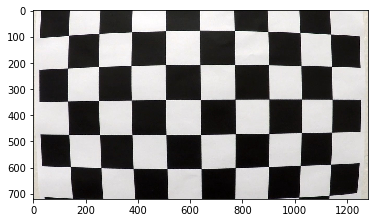

In [5]:
chessboard = mpimg.imread(cal_imgs[12])
plt.imshow(chessboard)

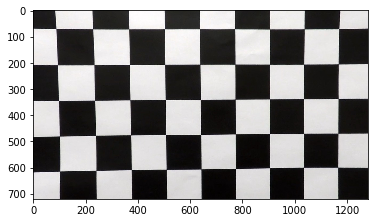

In [6]:
plt.imshow(cv2.undistort(chessboard, mtx, dist))

### test a road image

Here I undistort one of the [test_images](./test_images). I chose the one seen below, because it was also one that was commonly used in the Udacity lessons. 

In [7]:
test_image_dist = mpimg.imread(test_images[3])

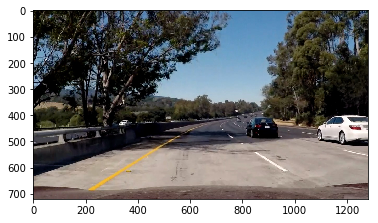

In [8]:
plt.imshow(test_image_dist)

In [9]:
test_image = cv2.undistort(test_image_dist, mtx, dist)

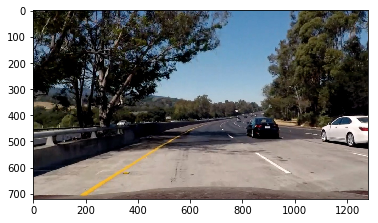

In [10]:
plt.imshow(test_image)

# Thresholding

## Gradient

### Sobel for x direction

I only used Sobel filtering in x direction, because y direction hardly gives useful information. To reduce noise I applied a lower bound threshold of 20. The upper bound I ended up with while experimenting around with high values. However, it did not make much of a difference if it was 150 or 200.

Sobel x performs well, but it reaches its limits on bright surfaces when trying to detect the yellow boundary line. 

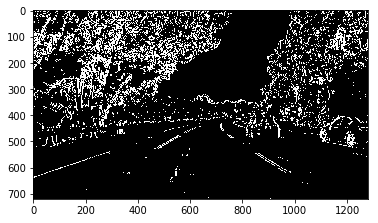

In [11]:
x_binary = lib.abs_sobel_thresh(test_image, orient='x', sobel_kernel=5, thresh=(20, 150))
plt.imshow(x_binary, cmap='gray')

## HLS

### S channel

Because edge detection reached it limit on a very bright surface, I experimented with the S channel of the HLS color space. The boundary line markings have a high saturation. Thus I chose relatively high thresholds.

However, now my problem was, that I was picking up bright elements close to the boundary line. This can be clearly seen for the left boundary in the picture below: for y between 400 and 500 there are too many things that are not filtered next to the boundary line.

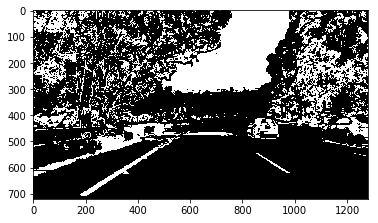

In [12]:
s_binary = lib.s_channel_threshold(test_image, thresh=(90, 255))[1]
plt.imshow(s_binary, cmap='gray')

### H channel

I used the channel to get better results for the left boundary line. The H value for orange is around 30° and yellow is 60°. On a scale from 0 to 255 (and after some experimenting) this translates to the threshold I use below.

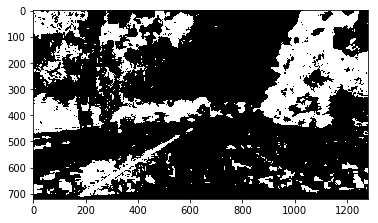

In [13]:
h_binary = lib.h_channel_threshold(test_image, thresh=(15, 50))[1]
plt.imshow(h_binary, cmap='gray')

## Combined HLS and Sobel thresholds

Here is how I combined the different channels: (H AND S) OR SobelX
I chose to do have AND for H and S because both have disturbing noise. SobelX does not have much noise, but is lacking some information, so I combine it with OR.

The result clearly displays the boundary lines without any surrounding disturbances close to them

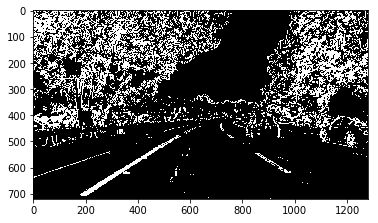

In [14]:
combined_binary = np.zeros_like(s_binary)
combined_binary[((h_binary == 1) & (s_binary == 1)) | (x_binary == 1)] = 1
plt.imshow(combined_binary, cmap='gray')

# Perspective Transform

I chose to do a perspective transform with the points shown below. The image will be transformed in such a way that the points become corners of a rectangle in the transformed image.

The binary image below shows the transformed image of the combined thresholds from the last section. The lanes are clearly visible and are hardly surrounded by noise.

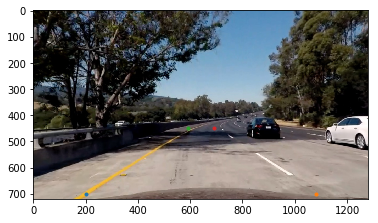

In [15]:
points = cv2.undistort(test_image.copy(), mtx, dist)
plt.plot(200, 700, '.')
plt.plot(1280 - 200, 700, '.')
plt.plot(590, 450, '.')
plt.plot(1280 - 590, 450, '.')
plt.imshow(points)

In [16]:
warped, M, M_inv = lib.warp(combined_binary)

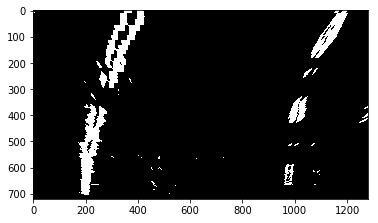

In [17]:
plt.imshow(warped, cmap ='gray')

# Fit lines

Here I use the method with histagrams and shifting windows, as introduced in the lessons. However, in the lessons 9 windows were used to cover a whole line. Since there can be quite big gabs between line segments on the right side, the windows can be too small, if the image is divided in 9 equal parts. I changed the interface of `fit_polynomial` to also take the amount of windows as an argument. Like that I was able to increase the window size by decreasing the amount of windows. Since `fit_polynomial` returns a quadratic function, probably even 3 windows would have been sufficient. However, 5 led to good results, so I stuck with it.

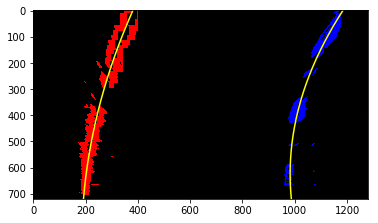

In [18]:
out_img, left_fitx, right_fitx = lib.fit_polynomial(warped, 5)

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

# Calculate curvature radius and displacement

I do the curvature calculation slightly differently than suggested in the lessons, especially regarding the first and second derivates.

I first change the x_fits that I used for plotting the polynomial and scale them from pixel to meter. The proportional factors `xm_per_pix` and `ym_per_pix` are provided in the lessons.
After transforming the x and y vectors to meters, I chose the point where I want to have my curvature. I chose the middle of the image ($y = 720 / 2$), because in some test cases the polynomial fit was not so good at $y = 0$ or $y = 719$. Then I compute the first and second derivate at those points numerically. Doing that, I do not have to do an extra polynomial fit. 

The curvature radius is only computed with the right lane boundary, because it provides better results in my processing pipeline. The left boundary is affected by noise more often and would need more robustness measures to give better results.

The lateral displacement was computed by finding the middle point of the lane at $y = 700$. I wanted a value as close to the vehicle as possible, but because a small part of the vehicle covers the bottom line of the image, I went for $y=700$ instead of $y=720$. After finding the middle point, I check its distance to the middle of the image. In the end I use `xm_per_pix` to get the displacement in meters.

In [19]:
rad = lib.calculateCurvature(right_fitx.copy(), ploty.copy())

In [20]:
dsp = lib.calculateDisplacement(right_fitx.copy(), left_fitx.copy())

# Project back

In [21]:
res = lib.unwarp(warped, test_image_dist, M_inv, left_fitx, right_fitx)

In [22]:
res = lib.addText(res, rad, dsp)

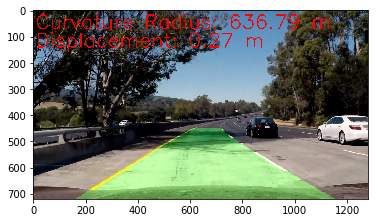

In [23]:
plt.imshow(res)

# Video pipeline

Here I assemble all previously described processing steps in one function. This function is then used to process all frames from the video data and returning a video highlighting the lane and showing the current curvature as well as the lateral displacement.

In [24]:
def pipeline(image):

    #Undistort
    img = cv2.undistort(image, mtx, dist)
    
    #Thresholding
    x_binary = lib.abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(20, 150))
    s_binary = lib.s_channel_threshold(img, thresh=(90, 255))[1]
    h_binary = lib.h_channel_threshold(img, thresh=(15, 50))[1]
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((h_binary == 1) & (s_binary == 1)) | (x_binary == 1)] = 1
    
    #Perspective Transform
    warped, M, M_inv = lib.warp(combined_binary)
    
    #Line Fitting
    left_fitx, right_fitx = lib.fit_polynomial(warped, 5)[1:]
    
    #Curvature and Displacement
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    rad = lib.calculateCurvature(right_fitx.copy(), ploty.copy())
    dsp = lib.calculateDisplacement(right_fitx.copy(), left_fitx.copy())
    
    #Unwarp
    result = lib.unwarp(warped, img, M_inv, left_fitx, right_fitx)
    
    #Add Text
    result = lib.addText(result, rad, dsp)
    
    return result

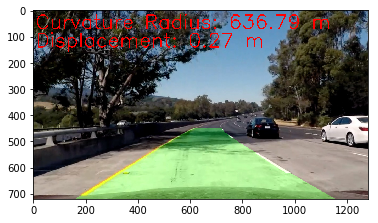

In [25]:
plt.imshow(pipeline(test_image_dist))

# Create Video

In [27]:
#Uncomment to create video

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip

clip1 = VideoFileClip("project_video.mp4")
project_output = 'project_output.mp4'
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(project_output, audio=False)


Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0835584/28549024 bytes (2.92433024/28549024 bytes (8.5%4923392/28549024 bytes (17.28552448/28549024 bytes (30.012451840/28549024 bytes (43.6%16261120/28549024 bytes (57.0%20144128/28549024 bytes (70.6%24068096/28549024 bytes (84.3%28000256/28549024 bytes (98.1%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [04:05<00:00,  5.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 1min 55s, sys: 12.3 s, total: 2min 8s
Wall time: 4min 8s
